In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/python/BayesianFiltering

/content/gdrive/MyDrive/python/BayesianFiltering


In [3]:
from ssm import StateSpaceModel
from ssm import LinearModelParameters
from SLDS import SLDS
from simulation import Simulation
from ssm import LGSSM
import numpy as np
import copy
import matplotlib.pyplot as plt

# Data Generation

In [4]:
M = 2
dx = 1
dy = 1
T = 100
model_parameter_array = np.empty([M], dtype=LinearModelParameters)
# var_max = 10
# correl_mask_dx = np.ones([dx, dx]) - np.eye(dx)
# for m in range(M):
#     A = np.random.rand() * np.eye(dx)
#     H = 1 * np.eye(dy, dx)
#     #Q_nonsym = var_max * np.multiply(np.random.random([dx, dx]), np.eye(dx)) + \
#     #          np.multiply(np.random.random([dx, dx]), correl_mask_dx)
#     #Q = 1 * (Q_nonsym + Q_nonsym.T)
#     Q = 0.1 * np.random.rand() * np.eye(dx)
#     R = 1000 * np.random.rand() * np.eye(dy)
#     model_parameter_array[m] = LinearModelParameters(A, H, Q, R)

# Slow forgetting
A0 = -1 * np.eye(dx)
H0 = 1 * np.eye(dy, dx)
Q0 = 1 * np.eye(dx) #np.array([[10, 0] , [ 0, 0.1]])
R0 = 1 * np.eye(dy)

# Fast forgetting
theta = np.pi*5/360
A1 = 1 # 1 * np.array([[np.cos(theta), -np.sin(theta)] , [ np.sin(theta), np.cos(theta)]])
H1 = 1 * np.eye(dy, dx)
Q1 = 0.01 * np.eye(dx) # np.array([[0.1, 0] , [ 0, 10]])
R1 = 5  * np.eye(dy)

model_parameter_array[0] = LinearModelParameters(A0, H0, Q0, R0)
model_parameter_array[1] = LinearModelParameters(A1, H1, Q1, R1)

SLDS = SLDS(dx, dy, model_parameter_array)

# alpha = np.random.choice(range(1, 50), M)
# mat = np.random.dirichlet(alpha, M) # Random tranisiton matrix with Dirichlet(alpha) rows
mat = np.array([[0.8, 0.2] , [ 0.2, 0.8]])

SLDS.set_transition_matrix(mat)

# Experiment 1
Compare Exact Conditional filtering (EC) to fixed-order GPB and IMM algorithms.

In [5]:
Nruns = 100
T = 100
r = 3
filt_init = [np.zeros(dx), np.eye(dx)]
init_state = np.zeros([dx])
avgErrEC_temp = np.zeros([Nruns])
avgErrIMM_temp = np.zeros([Nruns])
avgErrGPB_temp = np.zeros([Nruns])
for run in range(Nruns):
  simul = Simulation(SLDS, T, init_state=[0, init_state])
  trueStates = simul.states[1]
  ## Exact Conditional
  outEC = SLDS.conditional_kalman_filter(simul.states[0], simul.observs, filt_init)
  estEC = np.squeeze(outEC[0])
  ## IMM
  outIMM = SLDS.IMM(simul.observs, filt_init)
  estIMM = np.squeeze(outIMM[0])
  ## GPB
  outGPB = SLDS.GPB(r, simul.observs, filt_init)
  estGPB = np.squeeze(outGPB[0])
  ## Error Calculations
  avgErrEC_temp[run] = np.mean(np.linalg.norm(estEC - trueStates, axis = 1))
  avgErrIMM_temp[run] = np.mean(np.linalg.norm(estIMM - trueStates, axis = 1))
  avgErrGPB_temp[run] = np.mean(np.linalg.norm(estGPB - trueStates, axis = 1))  

In [6]:
[np.mean(avgErrEC_temp), np.mean(avgErrIMM_temp), np.mean(avgErrGPB_temp)]

[59.64317885712995, 60.13252738731339, 58.677323021250025]

# Experiment 2
Simulate for a range of r-values

In [17]:
Nruns = 50
T = 100
R = 9
filt_init = [np.zeros(dx), np.eye(dx)]
init_state = np.zeros([dx])
avgErrGPBr_temp = np.zeros([R-2, Nruns])
for run in range(Nruns):
  simul = Simulation(SLDS, T, init_state=[0, init_state])
  trueStates = simul.states[1]
  for r in range(2,R):
    ## GPB
    outGPB = SLDS.GPB(r, simul.observs, filt_init)
    estGPB = np.squeeze(outGPB[0])
    ## Error Calculations
    avgErrGPBr_temp[r-2, run] = np.mean(np.linalg.norm(estGPB - trueStates, axis = 1))

In [18]:
[np.mean(avgErrGPBr_temp[r-2]) for r in range(2,R)]

[56.80350164651024,
 56.3019765823873,
 55.86678302497427,
 55.556578856694486,
 55.39391099332118,
 55.266485718024775,
 55.22495357951395]

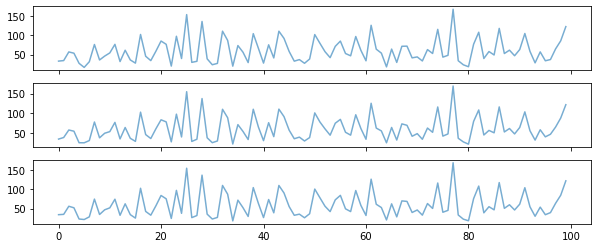

In [16]:
fig1, axes1 = plt.subplots(3, 1, sharex=True, figsize=(10, 4))
p1 = axes1[0].plot(avgErrEC_temp, alpha=0.6, label="States")
p2 = axes1[1].plot(avgErrIMM_temp, alpha=0.6, label="GPB")
p3 = axes1[2].plot(avgErrGPB_temp, alpha=0.6, label="IMM")
#axes1.set_ylabel("X")
#axes1.set_xlabel("time")
#axes1.set_title("True States VS Est")
#axes1.legend(['true', 'GPB', 'IMM'])

plt.show()